In [20]:
import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
from math import exp, factorial # funções matemáticas 'exp' e 'factorial'
import statsmodels.api as sm # estimação de modelos
import statsmodels.formula.api as smf # estimação de modelos de contagem
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos

import warnings
warnings.filterwarnings('ignore')

*Características de modelos para dados de contagem:*
 - Quantitivo;
 - Valor inteiro;
 - Não negativo;
 - Unidade por exposição (por exemplo, por hora, por dia, por mes, por rua, por bairro).

In [21]:
# Fisman, R.; Miguel, E. Corruption, Norms, and Legal Enforcement: Evidence
#from Diplomatic Parking Tickets.
# Journal of Political Economy, v. 15, n. 6, p. 1020-1048, 2007.
# https://www.journals.uchicago.edu/doi/abs/10.1086/527495

df_corruption = pd.read_csv('../data/corruption.csv', delimiter=',')
df_corruption.sort_values(by='violations', ascending=False).head(10)

,country,code,violations,staff,post,corruption
80,Egypt,EGY,167,24,no,0.248812
152,Kuwait,KWT,150,9,no,-1.073995
198,Nigeria,NGA,99,25,no,1.005368
170,Morocco,MAR,69,17,no,0.100878
36,Brazil,BRA,67,33,no,-0.096330
124,Indonesia,IDN,61,25,no,0.954828
212,Pakistan,PAK,61,13,no,0.755293
238,Senegal,SEN,59,11,no,0.450054
236,Sudan,SDN,56,7,no,0.745428
0,Angola,AGO,50,9,no,1.047506


In [22]:
# Características das variáveis do dataset
df_corruption.info()

# Estatísticas univariadas
df_corruption.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     298 non-null    object 
 1   code        298 non-null    object 
 2   violations  298 non-null    int64  
 3   staff       298 non-null    int64  
 4   post        298 non-null    object 
 5   corruption  298 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 14.1+ KB


,violations,staff,corruption
count,298.000000,298.000000,298.000000
mean,6.496644,11.805369,0.013641
std,18.210377,11.079558,1.012474
min,0.000000,2.000000,-2.582988
25%,0.000000,6.000000,-0.415147
50%,0.000000,9.000000,0.326959
75%,3.000000,14.000000,0.720250
max,167.000000,86.000000,1.582807


In [23]:
# Tabela de frequências da variável dependente 'violations'
# Função 'values_counts' do pacote 'pandas', sem e com o argumento
# 'normalize=True', para gerar as contagens e os percentuais, respectivamente

contagem = df_corruption['violations'].value_counts(dropna=False)
percent = (df_corruption['violations'].value_counts(dropna=False, normalize=True)*100).round(2)
table = pd.concat([contagem, percent], axis=1, keys=['contagem', '%'], sort=True)
table

,contagem,%
violations,,
0,156,52.35
1,35,11.74
2,16,5.37
3,17,5.70
4,5,1.68
5,10,3.36
6,3,1.01
7,4,1.34
8,3,1.01


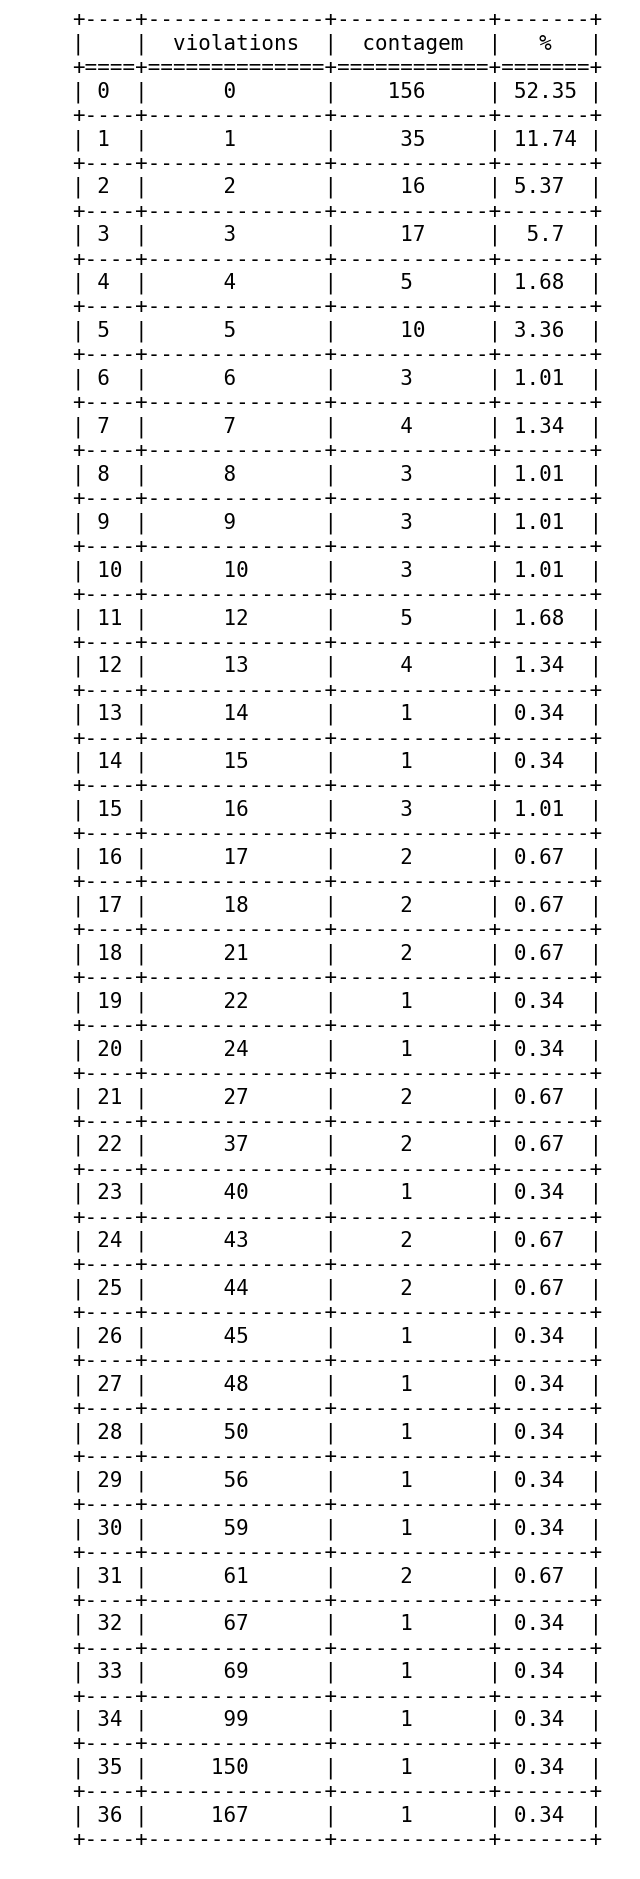

In [24]:
# Visualização da tabela de frequências da variável dependente 'violations'
# no ambiente Plots (apenas para fins didáticos)

table.reset_index(level=0, inplace=True)
table.rename(columns={'index': 'n'}, inplace=True)

from tabulate import tabulate
tabela = tabulate(table, headers='keys', tablefmt='grid', numalign='center')

plt.figure(figsize=(8, 3))
plt.text(0.1, 0.1, tabela, {'family': 'monospace', 'size': 15})
plt.axis('off')
plt.show()

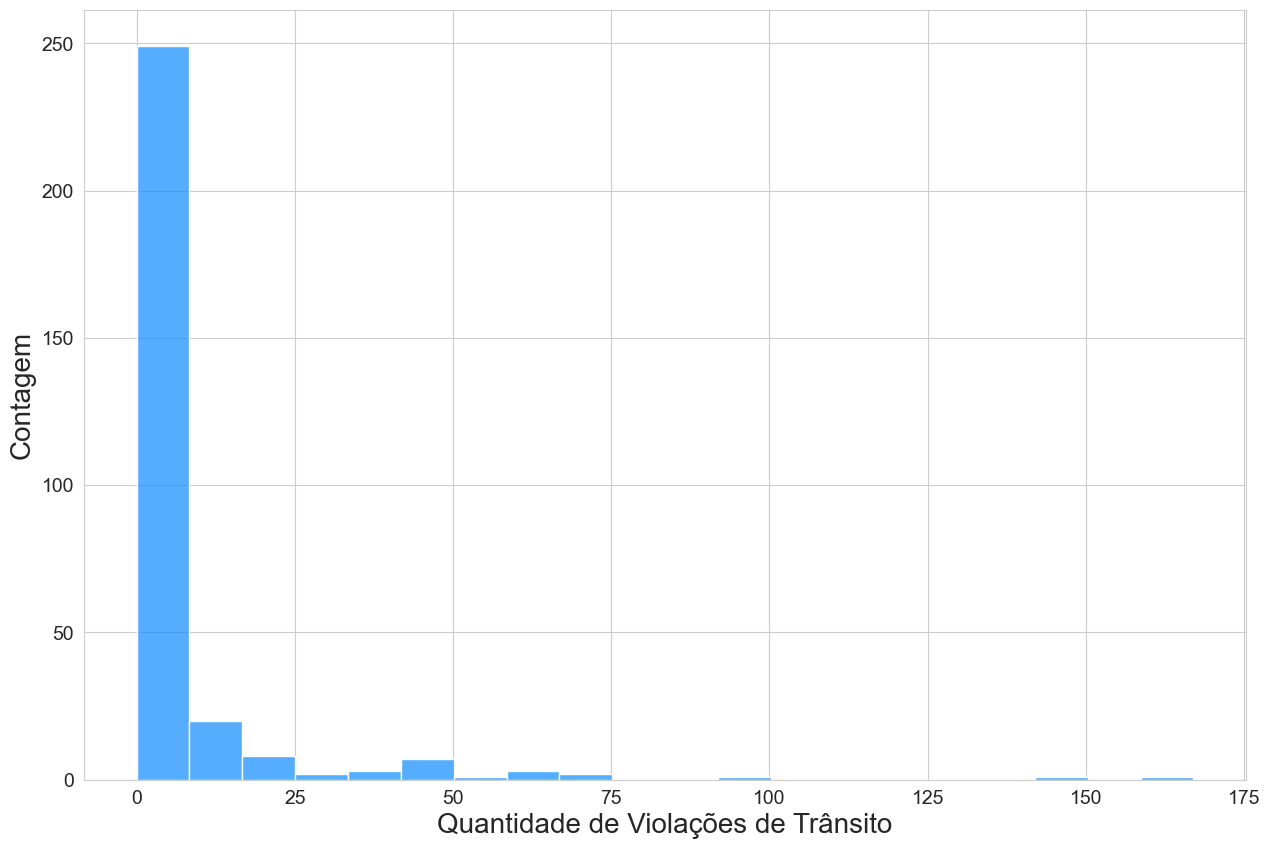

In [25]:
# Histograma da variável dependente 'violations'

with sns.axes_style("whitegrid"):
    plt.figure(figsize=(15,10))
    sns.histplot(data=df_corruption, x='violations', bins=20,
                 color='dodgerblue', edgecolor='white', kde=False)
    plt.xlabel('Quantidade de Violações de Trânsito', fontsize=20)
    plt.ylabel('Contagem', fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [26]:
# Diagnóstico preliminar para observação de eventual igualdade entre a
# média e a variância da variável dependente 'violations'

pd.DataFrame({'Média':[df_corruption.violations.mean()],
              'Variância':[df_corruption.violations.var()]})

,Média,Variância
0,6.496644,331.617834


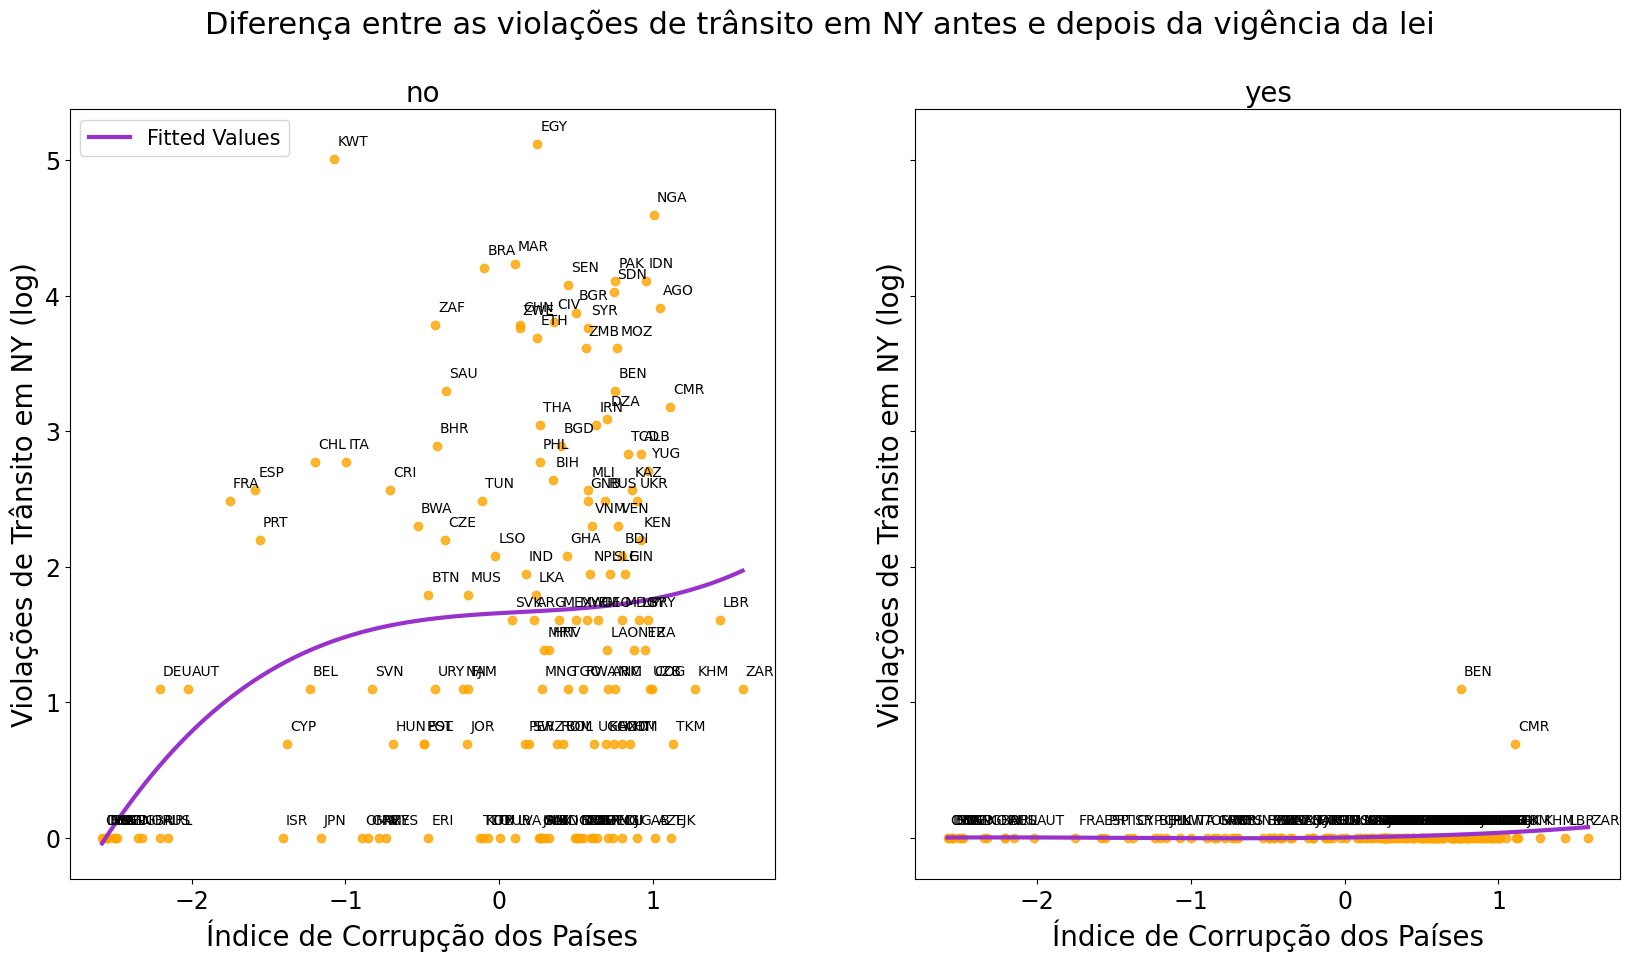

In [27]:
# Comportamento das variáveis 'corruption' e 'violations' antes e
# depois do início da vigência da lei

fig, axs = plt.subplots(ncols=2, figsize=(20,10), sharey=True)

fig.suptitle('Diferença entre as violações de trânsito em NY antes e depois da vigência da lei',
             fontsize=22)

post = ['no', 'yes']

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y']+.1, str(point['val']))

for i, v in enumerate(post):
    df = df_corruption[df_corruption.post==v]
    df['violations'] = np.log(df.violations)
    df.loc[df['violations'] == np.inf, 'violations'] = 0
    df.loc[df['violations'] == -np.inf, 'violations'] = 0
    sns.regplot(data=df, x='corruption', y='violations',
                order=3, ax=axs[i], ci=False,
                line_kws={'color':'darkorchid', 'linewidth': 3,
                          'label':'Fitted Values'},
                scatter_kws={'color':'orange'})
    axs[i].set_title(v, fontsize=20)
    axs[i].set_ylabel("Violações de Trânsito em NY (log)", fontsize=20)
    axs[i].set_xlabel("Índice de Corrupção dos Países", fontsize=20)
    label_point(df.corruption, df.violations, df.code, axs[i])

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=17)
    
axs[0].legend(loc='upper left', fontsize=15)

plt.show()

In [28]:
# Estimação do modelo Poisson

# O argumento 'family=sm.families.Poisson()' da função 'smf.glm' define a
# estimação de um modelo Poisson

modelo_poisson = smf.glm(formula='violations ~ staff + post + corruption',
                         data=df_corruption,
                         family=sm.families.Poisson()).fit()

# Parâmetros do 'modelo_poisson'
print(modelo_poisson.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             violations   No. Observations:                  298
Model:                            GLM   Df Residuals:                      294
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2071.8
Date:                Sat, 07 Sep 2024   Deviance:                       3644.0
Time:                        12:02:06   Pearson chi2:                 6.77e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.2127      0.031     71.134      

In [31]:
modelo_poisson.predict(pd.DataFrame({'staff':[28],
                                     'post':['no'],
                                     'corruption':[1]}))

0    23.733008
dtype: float64

In [11]:
modelo_poisson_aternativo = sm.Poisson.from_formula('violations ~ staff + post + corruption', 
                                                    df_corruption).fit()

print(modelo_poisson_aternativo.summary())

Optimization terminated successfully.
         Current function value: 6.952328
         Iterations 9
                          Poisson Regression Results                          
Dep. Variable:             violations   No. Observations:                  298
Model:                        Poisson   Df Residuals:                      294
Method:                           MLE   Df Model:                            3
Date:                Sat, 07 Sep 2024   Pseudo R-squ.:                  0.3992
Time:                        11:52:00   Log-Likelihood:                -2071.8
converged:                       True   LL-Null:                       -3448.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.2127      0.031     71.134      0.000       2.152       2.274
post[T.yes]    -4.2968    

In [12]:
# Outro modo mais completo de apresentar os outputs do modelo,
# pela função 'summary_col'

summary_col([modelo_poisson],
            model_names=["MODELO"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
        })

,MODELO
Intercept,2.2127***
,(0.0311)
post[T.yes],-4.2968***
,(0.1974)
staff,0.0219***
,(0.0012)
corruption,0.3418***
,(0.0275)
N,298
Log-lik,-2071.79


*Todas as variáveis preditoras se mostraram estatisticamente diferentes de zero, considerando-se um nível de significância de 5%, ceteris paribus. Porém, já se pode afirmar que a estimação Poisson é a mais adequada?*

### TESTE DE SUPERDISPERSÃO DE CAMERON E TRIVEDI (1990)
*CAMERON, A. C.; TRIVEDI, P. K. Regression-based tests for overdispersion in
the Poisson model. Journal of Econometrics, v. 46, n. 3, p. 347-364, 1990.*

 1) Passo: estimar um modelo Poisson;
 
 2) Passo: criar uma nova variável (Y*) utilizando os fitted values do modelo Poisson estimado anteriormente;
 
 3) Passo: estimar um modelo auxiliar OLS, com a variável Y* como variável dependente, os fitted values do modelo Poisson como única variável preditora e sem o intercepto;
 
 4) Passo: Observar a significância do parâmetro beta.

In [13]:
# Adicionando os fitted values do modelo Poisson ('lambda_poisson') ao dataframe
df_corruption['lambda_poisson'] = modelo_poisson.fittedvalues
df_corruption

# Criando a nova variável Y* ('ystar')
df_corruption['ystar'] = (((df_corruption['violations']
                            -df_corruption['lambda_poisson'])**2)
                          -df_corruption['violations'])/df_corruption['lambda_poisson']
df_corruption

# Estimando o modelo auxiliar OLS, sem o intercepto
modelo_auxiliar = sm.OLS.from_formula('ystar ~ 0 + lambda_poisson',
                                      df_corruption).fit()

# Parâmetros do 'modelo_auxiliar'
print(modelo_auxiliar.summary())

                                 OLS Regression Results                                
Dep. Variable:                  ystar   R-squared (uncentered):                   0.025
Model:                            OLS   Adj. R-squared (uncentered):              0.022
Method:                 Least Squares   F-statistic:                              7.584
Date:                Sat, 07 Sep 2024   Prob (F-statistic):                     0.00625
Time:                        11:52:00   Log-Likelihood:                         -1952.9
No. Observations:                 298   AIC:                                      3908.
Df Residuals:                     297   BIC:                                      3911.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

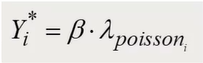

 - Se o p-value do beta for ``menor ou igual a 0,05`` -> ``superdispersão (Binomial Negativo)``

 - Se o p-value do beta for ``maior que 0,05`` -> ``equidispersão (Poisson)``

*Caso o p-value do parâmetro de lambda_poisson seja maior que 0.05, verifica-se a existência de equidispersão nos dados.*

*Caso contrário, diagnostica-se a existência de superdispersão nos dados, fato que favorecerá a estimação de um modelo binomial negativo, como ocorre nesse caso.*

In [14]:
# Função 'overdisp'
# Uma abordagem mais direta para a detecção da superdispersão pelo Teste de
# Cameron e Trivedi (1990) é por meio da utilização da função 'overdisp' do
# pacote 'statstests.tests'

# Instalação e carregamento da função 'overdisp' do pacote 'statstests.tests'
# Autores do pacote: Luiz Paulo Fávero e Helder Prado Santos
# https://stats-tests.github.io/statstests/

from statstests.tests import overdisp

# Elaboração direta do teste de superdispersão
overdisp(modelo_poisson, df_corruption)

Estimating model...: 
 GLM
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.022    
Dependent Variable:     ystar            AIC:                         3907.7809
Date:                   2024-09-07 11:52 BIC:                         3911.4780
No. Observations:       298              Log-Likelihood:              -1952.9  
Df Model:               1                F-statistic:                 7.584    
Df Residuals:           297              Prob (F-statistic):          0.00625  
R-squared (uncentered): 0.025            Scale:                       28915.   
-------------------------------------------------------------------------------------
            Coef.        Std.Err.         t          P>|t|        [0.025       0.975]
-------------------------------------------------------------------------------------
lmbda       2.6525         0.9632       2.7538       0.0063       0.7569       4.5480
-------------

In [19]:
# Apenas para fins didáticos, caso considerássemos a estimação Poisson
# como a mais adequada, qual seria a quantidade média esperada de violações
# de trânsito para um país cujo corpo diplomático fosse composto por 23 membros,
# considerando o período anterior à vigência da lei e cujo índice de corrupção
# seja igual a 0.5?

modelo_poisson.predict(pd.DataFrame({'staff':[23],
                                     'post':['no'],
                                     'corruption':[0.5]}))

# Qual seria a quantidade média esperada de violações de trânsito para o mesmo
# país, porém agora considerando a vigência da lei?

modelo_poisson.predict(pd.DataFrame({'staff':[28],
                                     'post':['no'],
                                     'corruption':[1]}))

0    23.733008
dtype: float64